# Precipiation and Infiltration in Landlab
<hr>
Created DATE for CSDMS Summer ESPIn Course
<hr>
Brooke Hunter - University of Oregon
<br /> 
Lisa Luna
<br /> 
Yuval Shmilovitz
<br /> 
Celia Trunz
<br /> 
Tianyue Qu
<hr>


## Overview of notebook
#### LandLab Components used
`PrecipitationDistribution`
`OverlandFlow`
`SoilInfiltrationGreenAmpt`
    
In this notebook we will explore the relationships between rainfall intensity, water stage height, and infiltration. This notebook connects multiple Landlab components. It expands upon the **Coupled rainfall-runoff model with OverlandFlow** tutorial (see link below). 

Rainfall data is typically collected by rain gauges in the field, but we will generate synthetic data with the `PrecipitationDistribtuion` component. From this output we will use rainfall-intensity values combined with infiltration rates from the `SoilInfiltrationGreenAmpt`component. Additionally we we calculate overlandflow values using `OverlandFlow`.

<hr>

<img align="right" src="https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/ConcepModel.png?raw=true" alt="drawing" width="600"/>

### Learning Objectives


Topical learning objectives
1. Concepts of rainfall intensity, storm depth, and hydraulic conductivity
2. Relationships between infiltration depth and hydraulic conductivity
3. Relationships between rainfall intensity

Python Skill Learning Objectives:
1. Communicate between two LandLab components with inputs and outputs
2. Set up a topographic elevation grid from an asci file 
3. Create plots using `matplotlib` 
4. Save figure to file


### Conceptual model

#### Step 1
Using the `PrecipitationDistribution` component in Landlab we will generate a single storm that is uniform in space, but varies in rainfall flux over the duration of the storm. This will be done on a simple catchment (`hugo_site.asc`). Rainfall flux will contribute to `surface_water_depth` which will be fed into `soil_water_infiltration__depth`.

#### Step 2
With the `SoilInfiltrationGreenAmpt`, we will calculate the `soil_water_infiltration__depth` and the new `surface_water__depth`. 

#### Step 3
This `surface_water__depth` term is also used in `OverlandFlow`! So now we can run the `OverlandFlow` to determine where (and how much) the water goes. 

<hr>

<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>

## Load the following packages

In [1]:
from landlab.components.uniform_precip import PrecipitationDistribution
import numpy as np
import random
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
from landlab import imshow_grid_at_node                                                                                                                               
from landlab.components import OverlandFlow
import matplotlib.colors as mcolors
from landlab.io import read_esri_ascii

## Set up a grid using topography from asci file.

In [2]:
## Import Hugo Site Asci File
fname = 'hugo_site.asc'

## Set up grid to have topographic elevation values of Hugo Site
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE #This line creates a closed boundary around catchment
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED
mg.set_watershed_boundary_condition('topographic__elevation')

## Visualization! 

In the first cell you will check that the boundary conditions are located in the right place around the catchment. 

In the second cell below you will plot the elevation of the Hugo catchment. 

C:\Users\brdeh\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\brdeh\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


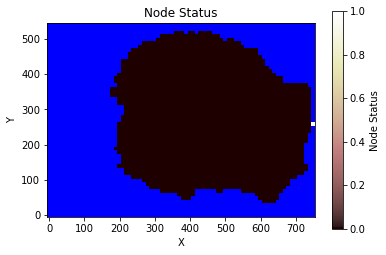

In [3]:
## Show boundries condition of the basin
fig = plt.subplots()
imshow_grid(mg, mg.status_at_node, color_for_closed="blue",
            plot_name = 'Node Status',
            var_name = 'Node Status')

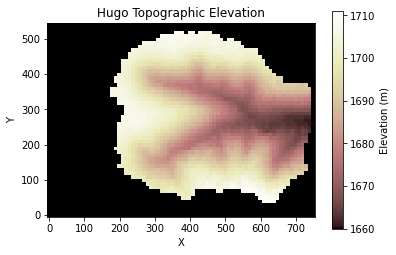

In [4]:
## Show basin topography
fig = plt.subplots()
imshow_grid(mg,                     
            values = z,
            plot_name = 'Hugo Topographic Elevation',
            var_name = 'Elevation (m)')

## Rainfall Generator
We will use the `PrecipitationDistribution` component in LandLab to generate storm events and calculate rainfall intensity and strom depth values! 

<hr>

<img align="right" src = "https://github.com/espin-2020/precipitation_lanscape_evolution/blob/master/RainfallInten.png?raw=true" alt="drawing" width="600">

<br /> 
<br /> 

### Rainfall intensity
Rainfall intensity is defined as the depth of rainfall over a specfic period (often expressed in mm/hr). Here is a schematic of rain gauges and example rainfall intensity calculations. The rain gauge on the left has collected 2mm of rain in two hours while the one on the right collected 5mm of rain in two hours. This results in a rainfall intensity of 1mm/hr and 2.5mm/yr respectively. 

### Storm depth
background on storm depth
Storm depth is defined as the depth of rain that falls during a storm over a specific duration as if distributed evenly across the landscape? Is  this basically what we use to calculate rainfall intensity. Add more here? Maybe an equation?

### Define parameters and initialize PrecipitationDistribution

In [5]:
## Define parameters for rainfall generator 
mean_duration = 6 ## hours, storm duration
mean_inter_duration = 20 ## hour,  duration between storms
mean_depth = 20   ## mm
total_time  = 24*30 ## 24 hours * 30 days
delta_t = 1; ## hour
np.random.seed(np.arange(10))

# Initialize generator
precip = PrecipitationDistribution(mg, mean_storm_duration=mean_duration, 
                                   mean_interstorm_duration=mean_inter_duration, 
                                   mean_storm_depth=mean_depth, total_t=total_time,delta_t=delta_t)
n = random.randint(1,101) ## random seed number 
precip.seed_generator(seedval=n)

## Generate rainfall series

In [6]:
## Iterating on all of the storms and save rainfall data

# Arrays for saving the outputs.
storm_dts = []
interstorm_dts = []
intensities = []
depths  = [] 
total_time=0
time_vec =[0]
rain_vec = [0]
for (storm_dt, interstorm_dt) in precip.yield_storms():
        ## Save rainfall data

    storm_dts.append(np.array(storm_dt)) ## hours
    interstorm_dts.append(interstorm_dt) ## hours
    intensities.append(mg.at_grid['rainfall__flux']) ## mm/h
    depths.append(mg.at_grid['rainfall__flux']*storm_dt)
    ## Creating rainfall time-series
    total_time += 1
    time_vec.append(total_time)
    rain_vec.append(intensities[-1])
    total_time += storm_dt
    time_vec.append(total_time)
    rain_vec.append(intensities[-1])
    total_time += 1
    time_vec.append(total_time)
    rain_vec.append(0)
    total_time += interstorm_dt
    time_vec.append(total_time)
    rain_vec.append(0)

time_vec = np.asanyarray(time_vec)*60 ##in minutes
rain_vec = np.asanyarray(rain_vec)

## Plot Rainfall series


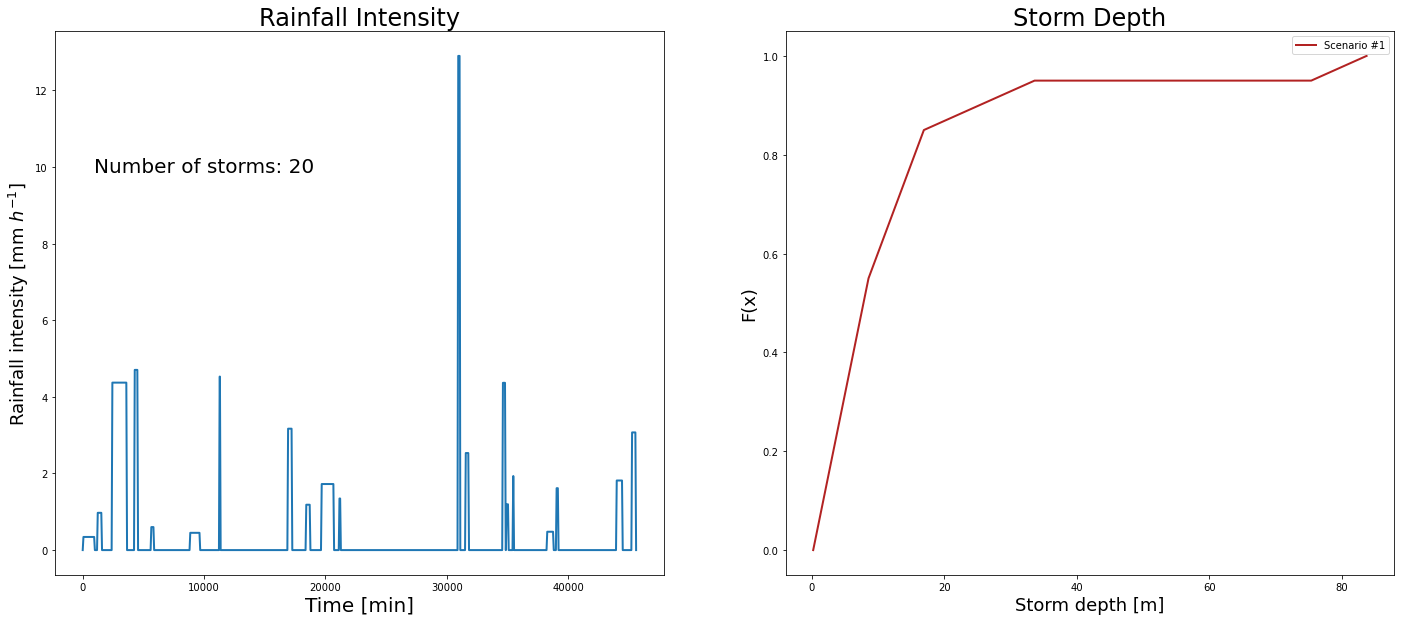

In [24]:
fig, ax = plt.subplots(1,2, figsize = (24,10))

## Plotting the full rainfall series
number_of_storms = str(len(storm_dts))
ax[0].plot(time_vec,rain_vec,linewidth=2)   
ax[0].set_xlabel('Time [min]',fontsize=20)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=18)
ax[0].set_title('Rainfall Intensity',fontsize=24)
ax[0].text(10000, 10,'Number of storms: ' + number_of_storms, horizontalalignment='center', verticalalignment='center', fontsize =20)

## Plotting rainstorm depth CDF-plot

hist, bin_edges = np.histogram(depths) # This part was giving an error?, normed=True)
b = [0]
b.extend(np.cumsum(hist)/np.sum(hist))
ax[1].plot(bin_edges,b,label='Scenario #1',linewidth=2,color='firebrick')
ax[1].set_xlabel('Storm depth [m]',fontsize=18)
ax[1].set_ylabel('F(x)',fontsize=18)
ax[1].set_title('Storm Depth',fontsize=24)
ax[1].legend()

## Define Parameters for infiltration model
provide background on water stuff
### Hydraulic conductivity

### Overlandlandflow

In [ ]:
## Define parameters of infiltration component
HC = 1.0E-5
hydraulic_conductivity = mg.ones('node')* HC
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d = mg.at_node['soil_water_infiltration__depth']
d *= 0.2

## Surface water
mg.add_zeros('surface_water__depth',at='node')  # a veneer of water  the model
h = mg.at_node['surface_water__depth']
h += 0.0001

In [ ]:
## Initialize model
SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity)
of = OverlandFlow(mg, steep_slopes=True)

In [ ]:
## Loty

In [ ]:

## Change storm times to minutes
interstorm_dts_min = np.asanyarray(interstorm_dts)*60 ## in minutes
storm_dts_min = np.asanyarray(storm_dts)*60 ## in minutes
global_time = np.sum(interstorm_dts_min) + np.sum(storm_dts_min)


## Arrays for saving inputs and counters
SI_mean_vec = []
outlet_depth = []
outlet_times = []
elapsed_time = 0
node_of_max_q = 2126

## Better color map for plotting overlandflow
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)


In [ ]:

## Main loop
for i in  range(0,len(storm_dts_min)):
    storm_t = storm_dts_min[i]
    interstorm_t = interstorm_dts_min[i]
    total_time_step = storm_t + interstorm_t
    storm_time = 0 
    print(str(np.round((elapsed_time/global_time)*100))+ '% from total run time')
    while storm_time < total_time_step:
        if storm_time < (total_time_step - interstorm_t):
            mg.at_node['surface_water__depth'] += (intensities[i]/(60))*0.001*10 ## meter in 10 minutes
            dt_overland = 10 
            SI.run_one_step(dt=dt_overland)
            SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
            of.run_one_step(dt=dt_overland)
            elapsed_time += dt_overland
            outlet_times.append(elapsed_time) 
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            storm_time += dt_overland
        else:
            SI.run_one_step(dt=dt_overland)
            of.run_one_step(dt=dt_overland)
            SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
            # Increased elapsed time
            elapsed_time += dt_overland
            outlet_times.append(elapsed_time) 
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            storm_time += dt_overland 
        if elapsed_time % 1000 == 0:    
            fig = plt.figure(1)
            imshow_grid(mg,'topographic__elevation',colorbar_label='Elevation (m)')
            imshow_grid(mg,'surface_water__depth',limits=(0,0.6),cmap=cmap,colorbar_label='Water depth (m)')
            plt.title(f'Time = {round(elapsed_time,1)} s')
            plt.show()

# Question #

#### Plot the stage water level and the *total* infiltration over the duration of the storm.

#a. How does water stage heigh

#b. Re-run the code above for different mean storm duration, hydraulic conductivity, and mean strom depth.
- How does changing the mean storm duration affect the stage water level?
- How does changing the hydraulic conductivity affect the total infiltration?


In [ ]:
fig, ax = plt.subplots(2,1, figsize = (20,16))

number_of_storms = str(len(storm_dts))
ax[0].plot(time_vec,rain_vec,linewidth=2)   
ax[0].set_xlabel('Time [min]',fontsize=20)
ax[0].set_ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=18)

#plt.plot(outlet_times,outlet_depth,color='blue',linewidth=2)
ax[1].plot(outlet_times,outlet_depth,color='blue',linewidth=2)
#plt.ylabel('Water level [m]',color='blue',fontsize=20)
ax[1].set_ylabel('Stage Water level [m]',color='blue',fontsize=20)
#plt.xlabel('Time [min]',fontsize=20)
ax[1].set_xlabel('Time [min]',fontsize=20)

ax2=ax[1].twinx()
ax2.plot(outlet_times,SI_mean_vec,color="red",linewidth=2)
ax2.set_ylabel("Total Infiltration [mm]",color="red",fontsize=20)

# to save your figure to a file, specify a name before the final plotting command
plt.savefig('Output_stormDuration' + '_MeanDuration' + str(mean_duration) + '_MeanDepth' + str(mean_depth) + '_HC' + str(HC) +'.png')

# Question 3

# Question 1



In [ ]:
print(hydraulic_conductivity)

In [ ]:
str(mean_depth)